In [1]:
from dataloader import EmbeddingsDataloader
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot
from model import *
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import time
import numpy as np
import copy
from train import run_training, Run

c:\Users\nataxcan\miniconda3\envs\compviz2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


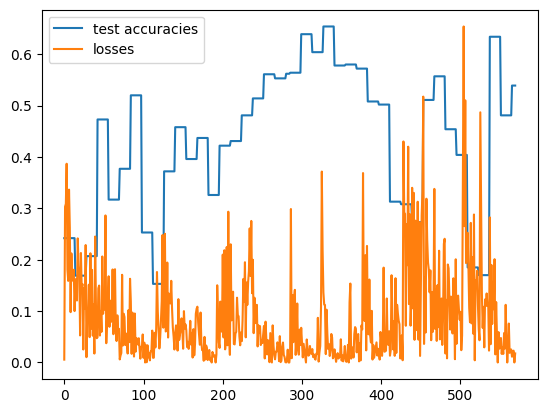

In [2]:
# sample run
r = Run()
losses, test_accs, best_model = r.run_experiment()
r.plot_results()

In [3]:
import itertools

# this is a simple experiment to see if there is a link
# between model capacity and performance
models = [
    SingleLayerPerceptron,
    MultiLayerPerceptron2,
    MultiLayerPerceptron3,
    MultiLayerPerceptron4,
]
widths = [
    1,
    4,
    16,
    64,
]
combinations = list(itertools.product(models, widths))
number_of_experiments_to_average_over = 10
raw_results = []
results = []


for i, elems in tqdm(enumerate(combinations), total=len(combinations), desc='combinations progress'):
    raw_results.append([])
    losses_sum = None
    test_accs_sum = None
    for _ in range(number_of_experiments_to_average_over):
        # run the experiment
        model, width = elems
        r = Run(model=model, frames_per_datapoint=width)
        losses, test_accs, best_model = r.run_experiment()
        # sum the results (for averaging later)
        results.append((max(test_accs), losses, test_accs, str((model, width))))
        if isinstance(losses_sum, type(None)):
            losses_sum = np.array(losses)
            test_accs_sum = np.array(test_accs)
        else:
            losses_sum += np.array(losses)
            test_accs_sum += np.array(test_accs)
    # average the results
    avg_losses = losses_sum / number_of_experiments_to_average_over
    avg_test_accs = test_accs_sum / number_of_experiments_to_average_over
    results.append(max(avg_test_accs), str(elems), str(model), width, avg_losses, avg_test_accs)

# which combination gave the best average performance?
results.sort()
[print(R) for R in results]

combinations progress:   0%|          | 0/16 [00:00<?, ?it/s]